In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
#%matplotlib inline
%matplotlib notebook

In this notebook we intend to create a simulation of a machine learning algorithm for the control of a system. For the simulation of a dynamical system we use the analogy of a ball in a dispersive harmonic potential with a random noise to disturb equilibrium.

The objective of the algorithm is to generate a force balancing the ball on top of the "hill". As an example this could represent the control of the temperature of a system. When the temperature is perturbed out of the desired value the algorithm generates a response correcting the difference.

For the machine learning algorithm we make use of an Extreme Learning Machine (ELM) due to it's application in all optical systems. If the system alters the beam shape based on the temperature it is possible to apply an all optical control system.

# System (No control)

In [302]:
def restoring_force():
    return 0.

def potential(x, k):
    return -k*x

def func(x, k, random, potential=potential, restoring_force=restoring_force):
    r = np.zeros(2)
    
    r[0] = x[1]
    r[1] = potential(x[0], k) + random - restoring_force()
        
    return r
    
def RK4(x, k, dt, random, potential=potential, restoring_force=restoring_force, func=func):
    K0 = dt*func(x, k, random[0])
    K1 = dt*func(x + K0/2, k, random[1])
    K2 = dt*func(x + K1/2, k, random[1])
    K3 = dt*func(x + K2, k, random[2])
    return (K0+2.*K1+2.*K2+K3)/6.
    
def system(T, k, dt, potential=potential, restoring_force=0., RK4=RK4):
    
    positions = np.zeros((2, T))
    random = np.zeros(3)
        
    for t in range(1, T):
        random[1:] = [np.random.normal(0.,1.) for i in range(2)]

        positions[:,t] = positions[:,t-1] + RK4(positions[:,t-1], k, dt, random)
        
        random[0] = random[-1]
        
    return positions

In [303]:
dt = 10**-3

k = 100.

m = 1.

T = 10000

history = system(T, k, dt, restoring_force=0.)

<IPython.core.display.Javascript object>


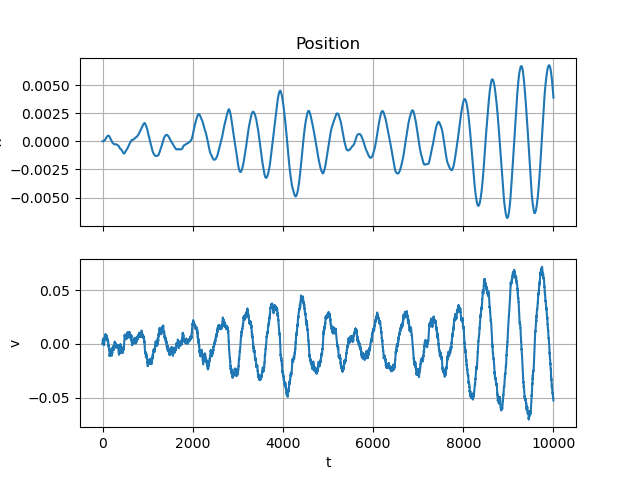

In [304]:
fig, axs = subplots(2)
axs[0].set_title("Position")
axs[0].plot(history[0])
axs[0].set_ylabel("x")
axs[0].set_xticklabels([])
axs[0].grid()

axs[1].plot(history[1])
axs[1].set_ylabel("v")
axs[1].set_xlabel("t")
axs[1].grid()

# System (Control on)

### ELM:

In [402]:
def g(x):
    return 1. + 1.*x + 1.*x**2

def g(x):
    return 1/(1+np.exp(-x))

## EXTREME LEARNING MACHINE
def ELM(x, y, n=10, g=g):
    # step 1
    w, b = np.random.uniform(0.,1., (n)), np.random.uniform(0.,1., n)
    #w, b = np.linspace(0.,1.,n), np.linspace(0.,1.,n)
    
    # step 2
    wxb = np.array([[w[i]*x[j] for i in range(n)] for j in range(x.shape[0])])
    print(wxb.shape)
    
    #wxb = np.sum(wxb, axis=2)
    
    H = g(wxb)
    
    #  pseudo-inverse
    Ht = np.linalg.pinv(H, hermitian=False)
        
    B = np.array([np.sum(Ht[i]*y) for i in range(n)])
    
    return B, H, w, b

## EXTREME LEARNING MACHINE
def ELM_test(x, w, n=10, g=g):
    wxb = np.array([np.sum(w[i]*x) for i in range(n)])

    H = g(wxb)
    return H

In [416]:
def restoring_force(state, w, B, n, ELM_test=ELM_test):
    H = ELM_test(state, w, n=n)
    
    t = np.array([np.sum(H[i]*B) for i in range(1)])
    
    return t
    
def potential(x, k):
    return k*x

def func(x, k, m, random, B, w, n, potential=potential, restoring_force=restoring_force, ELM_test=ELM_test):
    r = np.zeros(3)
    
    r[0] = x[1]
    r[1] = (potential(x[0], k) + random - restoring_force(x[[0,2]], w, B, n, ELM_test=ELM_test))/m
    r[2] = r[1]
    return r
    
def RK4(x, k, m, dt, random, w, B, n, potential=potential, restoring_force=restoring_force, func=func, ELM_test=ELM_test):
    K0 = func(x, k, m, random[0], B, w, n, ELM_test=ELM_test)
    K0[:2] = K0[:2]*dt
    K1 = func(x + K0/2, k, m, random[1], B, w, n, ELM_test=ELM_test)
    K1[:2] = K1[:2]*dt
    K2 = func(x + K1/2, k, m, random[1], B, w, n, ELM_test=ELM_test)
    K2[:2] = K2[:2]*dt
    K3 = func(x + K2, k, m, random[2], B, w, n, ELM_test=ELM_test)
    K3[:2] = K3[:2]*dt
    return (K0+2.*K1+2.*K2+K3)/6.
    
def system(T, k, m, dt, B, w, n, potential=potential, restoring_force=restoring_force, ELM=ELM, ELM_test=ELM_test, RK4=RK4):
    
    positions = np.zeros((3, T))
    random = np.zeros(3)
    
    for t in range(1, T):
        random[1:] = [np.random.normal(0.,1.) for i in range(2)]

        positions[:,t] = positions[:,t-1] + RK4(positions[:,t-1], k, m, dt, random, w, B, n, ELM_test=ELM_test)
        positions[2,t] = positions[2,t]-positions[2,t-1]
        
        random[0] = random[-1]
        
    return positions

(1000, 20)


<IPython.core.display.Javascript object>


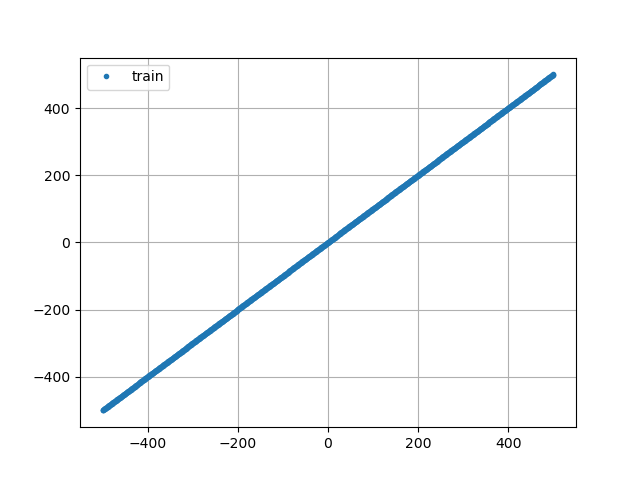

In [421]:
l1 = 5.
l2 = 0.5

N = 1000

x = np.linspace(-l1,l1,int(N))
a = np.linspace(-l2,l2,N)

X_train = np.array([x,a]).T

X_train = np.array([[[x[i], a[j]] for i in range(int(N))] for j in range(N)])

X_train = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 2))

#X_train = X_train[:,::-1]

def R(s, m, k, mean):
    return (k*s + mean)# + m*s[1]# 

y_train = np.array([R(x[i], m, k, 0.) for i in range(int(N))])

n = 20

B, H, w, b = ELM(x, y_train, n=n, g=g)

t = np.array([np.sum(H[i]*B) for i in range(len(y_train))])

fig, axs = subplots(1)
axs.plot(t,y_train,".", label="train")
#axs.plot(t, label="regression")
axs.legend()
axs.grid()

In [422]:
T = 10000

history = system(T, k, m, dt, B, w, n)

/home/vic/miniconda3/envs/keras_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


<IPython.core.display.Javascript object>


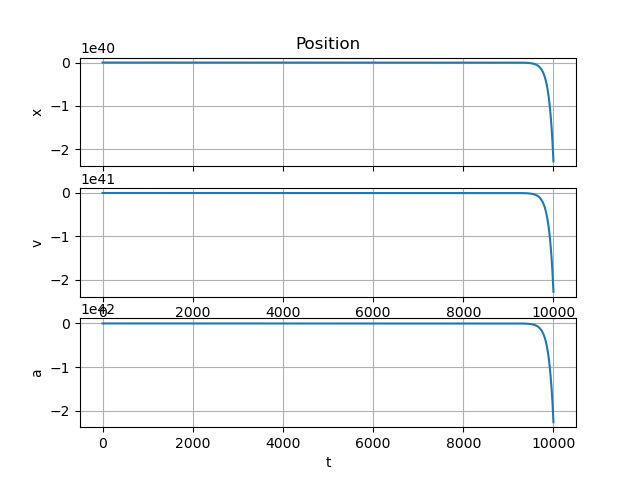

In [423]:
fig, axs = subplots(3)
axs[0].set_title("Position")
axs[0].plot(history[0])
axs[0].set_ylabel("x")
axs[0].set_xticklabels([])
axs[0].grid()

axs[1].plot(history[1])
axs[1].set_ylabel("v")
axs[1].set_xlabel("t")
axs[1].grid()

axs[2].plot(history[2])
axs[2].set_ylabel("a")
axs[2].set_xlabel("t")
axs[2].grid()